In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import pandas as pd


raw_data = pd.read_csv("/kaggle/input/nypd-complaints-historic/NYPD_Complaint_Data_Historic.csv")

/tmp/ipykernel_3132/3659503197.py:8: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("/kaggle/input/nypd-complaints-historic/NYPD_Complaint_Data_Historic.csv")


In [2]:
raw_data.shape

(7375993, 35)

In [3]:
raw_data.head(5)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,394506329,12/31/2019,17:30:00,NaN,NaN,32.0,12/31/2019,118,DANGEROUS WEAPONS,793.0,...,NaN,NaN,40.820927,-73.943324,"(40.82092679700002, -73.94332421899996)",PATROL BORO MAN NORTH,NaN,UNKNOWN,UNKNOWN,E
1,968873685,12/29/2019,16:31:00,12/29/2019,16:54:00,47.0,12/29/2019,113,FORGERY,729.0,...,NaN,NaN,40.885701,-73.861640,"(40.885701406000074, -73.86164032499995)",PATROL BORO BRONX,NaN,UNKNOWN,UNKNOWN,E
2,509837549,12/15/2019,18:45:00,NaN,NaN,109.0,12/29/2019,578,HARRASSMENT 2,638.0,...,M,NaN,40.742281,-73.819824,"(40.74228115600005, -73.81982408)",PATROL BORO QUEENS NORTH,NaN,25-44,WHITE HISPANIC,F
3,352454313,12/28/2019,01:00:00,NaN,NaN,47.0,12/28/2019,126,MISCELLANEOUS PENAL LAW,117.0,...,M,NaN,40.875311,-73.847545,"(40.87531145100007, -73.84754521099995)",PATROL BORO BRONX,NaN,UNKNOWN,UNKNOWN,E
4,248803469,09/05/2008,21:41:00,NaN,NaN,NaN,09/05/2008,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,NaN,NaN,40.698827,-73.938819,"(40.698827283, -73.938819047)",NaN,NaN,25-44,BLACK,M


In [4]:
raw_data = raw_data[["CMPLNT_FR_DT", "Latitude", "Longitude"]].dropna()

In [5]:
day_one = np.datetime64('2006-01-01')

# Convert the date column to datetime format and filter valid dates after '2006-01-01'
valid_dates = pd.to_datetime(raw_data['CMPLNT_FR_DT'], format='%m/%d/%Y', errors='coerce')
valid_dates = valid_dates[(valid_dates >= day_one)]

# Calculate the number of days since '2006-01-01' for valid dates and cast to float
days_since_2006 = (valid_dates - day_one).dt.days.astype(float)

In [6]:
days_since_2006

0          5112.0
1          5110.0
2          5096.0
3          5109.0
4           978.0
            ...  
7375988    4733.0
7375989    4538.0
7375990    4423.0
7375991    4727.0
7375992    4512.0
Name: CMPLNT_FR_DT, Length: 7338505, dtype: float64

In [7]:
rd = raw_data.copy()

# Number of standard deviations for filtering
std_devs = 3

# Outliers for the 'Latitude' column
lat_mean = rd['Latitude'].mean()
lat_std = rd['Latitude'].std()
rd = rd[(rd['Latitude'] > lat_mean - std_devs * lat_std) & (rd['Latitude'] < lat_mean + std_devs * lat_std)]

# Outliers for the 'Longitude' column
lon_mean = rd['Longitude'].mean()
lon_std = rd['Longitude'].std()
rd = rd[(rd['Longitude'] > lon_mean - std_devs * lon_std) & (rd['Longitude'] < lon_mean + std_devs * lon_std)]

In [8]:
min_lat, max_lat = min(rd["Latitude"]), max(rd["Latitude"])
min_lng, max_lng = min(rd["Longitude"]), max(rd["Longitude"])

In [9]:
GRID_LNG_DIM = 100
GRID_LAT_DIM = 120

# Calculate step sizes for latitude and longitude grids
lng_step = (max_lng - min_lng) / (GRID_LNG_DIM - 1)
lat_step = (max_lat - min_lat) / (GRID_LAT_DIM - 1)

def to_grid_lat(lat):
    return ((lat - min_lat) / lat_step)

def to_grid_lng(lng):
    return ((lng - min_lng) / lng_step)

data = pd.DataFrame({
    'CMPLNT_FR_DT': rd['CMPLNT_FR_DT'],
    'Days': days_since_2006,
    'GridLat': to_grid_lat(rd['Latitude']),
    'GridLng': to_grid_lng(rd['Longitude'])
})

data = data.dropna()
data['Days'] = data['Days'].astype('int16')
data["GridLat"] = data["GridLat"].astype("int16")
data["GridLng"] = data["GridLng"].astype("int16")
data = data.sort_values(by='Days')

In [10]:
# data

In [11]:
crime_grid_n = np.zeros((max(data["Days"]) + 1, GRID_LNG_DIM + 1, GRID_LAT_DIM + 1), dtype="float32")
crime_grid_n[data["Days"], data["GridLng"], data["GridLat"]] = 1
crime_grid_n[15][30]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [12]:
# len(crime_grid_n[crime_grid_n == 1]) / crime_grid_n.size

In [13]:
index = np.arange(1,31)[None, :] + np.arange(5449)[:, None] 
# Use the past 29 days to predict crime occurrences on the 30th day

In [14]:
x = crime_grid_n[index]

In [15]:
X = x[:, :29, :, :, None]
y = x[:, 29, :, :, None]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [17]:
y_train[0][1].shape

(121, 1)

In [18]:
# X_train.head()

In [19]:
import tensorflow as tf

D1017 17:30:28.537601972    3132 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1017 17:30:28.537636445    3132 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1017 17:30:28.537640111    3132 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1017 17:30:28.537642729    3132 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1017 17:30:28.537645257    3132 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1017 17:30:28.537647658    3132 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1017 17:30:28.537650219    3132 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1017 17:30:28.

In [20]:
#import tensorflow as tf


# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', patience=2)


Callbacks = callbacks = [es]


# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = Sequential()
    model.add(ConvLSTM2D(1, kernel_size=(3, 3), activation='tanh',
                        return_sequences=False,
                        padding='same',
                        data_format='channels_last'))

    model.compile(optimizer=Adam(),
              loss='binary_crossentropy',  
              metrics=['accuracy'])
    
    model.fit(X_train, y_train,
          batch_size=120,
          epochs=10,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=Callbacks)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Epoch 1/10


2023-10-17 17:31:02.118496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-17 17:31:02.276610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


37/37 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.9260

2023-10-17 17:31:50.966852: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-17 17:31:51.068629: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


37/37 [==============================] - 63s 1s/step - loss: 0.5281 - accuracy: 0.9260 - val_loss: 0.4264 - val_accuracy: 0.9256
Epoch 2/10
37/37 [==============================] - 26s 716ms/step - loss: 0.3448 - accuracy: 0.9260 - val_loss: 0.2789 - val_accuracy: 0.9256
Epoch 3/10
37/37 [==============================] - 26s 711ms/step - loss: 0.2511 - accuracy: 0.9260 - val_loss: 0.2333 - val_accuracy: 0.9256
Epoch 4/10
37/37 [==============================] - 26s 712ms/step - loss: 0.2240 - accuracy: 0.9260 - val_loss: 0.2179 - val_accuracy: 0.9256
Epoch 5/10
37/37 [==============================] - 26s 717ms/step - loss: 0.2123 - accuracy: 0.9260 - val_loss: 0.2078 - val_accuracy: 0.9256
Epoch 6/10
37/37 [==============================] - 26s 714ms/step - loss: 0.2024 - accuracy: 0.9263 - val_loss: 0.1981 - val_accuracy: 0.9266
Epoch 7/10
37/37 [==============================] - 26s 714ms/step - loss: 0.1929 - accuracy: 0.9283 - val_loss: 0.1887 - val_accuracy: 0.9292
Epoch 8/10
37

In [ ]:
model.summary()

In [21]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

35/35 [==============================] - 12s 234ms/step - loss: 0.1680 - accuracy: 0.9319
Test loss: 0.16803078353405
Test accuracy: 0.9319332838058472


In [23]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


2023-10-17 17:37:00.137882: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-17 17:37:00.209040: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 4s 4s/step


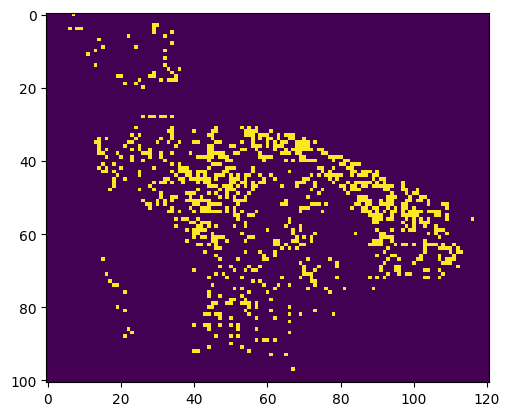

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

r = y_test[0][:,:,0]
p = np.round(model.predict(X_test[:2]), decimals=0)[0][:, :, 0]

plt.imshow(r)

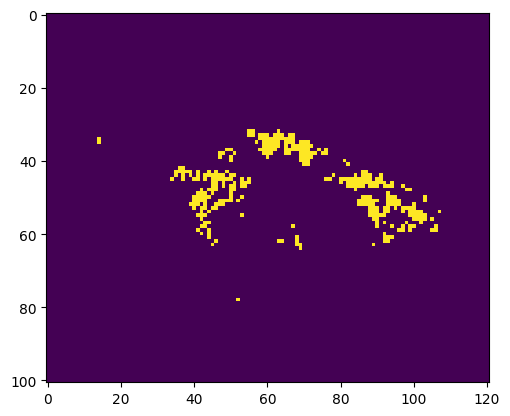

In [25]:
plt.imshow(p)